In [7]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
import numpy as np

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

# torch.manual_seed(12345678)
# np.random.seed(12345678)

0
tensor([[-5.3821],
        [-4.7696]], grad_fn=<CopyBackwards>)
tensor([[-5.5568],
        [-6.6159]], grad_fn=<CopyBackwards>)
(1800, 2)


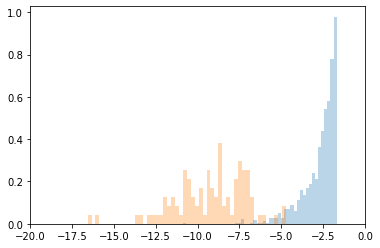

1
tensor([[-5.3673],
        [-4.5609]], grad_fn=<CopyBackwards>)
tensor([[-5.9927],
        [-7.3454]], grad_fn=<CopyBackwards>)
(2600, 2)


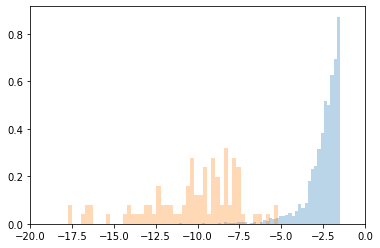

2
tensor([[-5.3824],
        [-4.3537]], grad_fn=<CopyBackwards>)
tensor([[-6.5558],
        [-7.2717]], grad_fn=<CopyBackwards>)
(3400, 2)


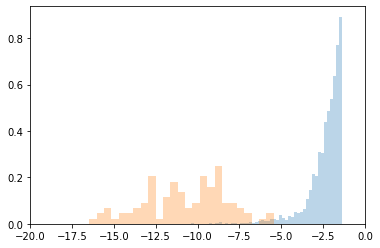

3
tensor([[-5.2255],
        [-4.0958]], grad_fn=<CopyBackwards>)
tensor([[-7.3386],
        [-9.7157]], grad_fn=<CopyBackwards>)
(4200, 2)


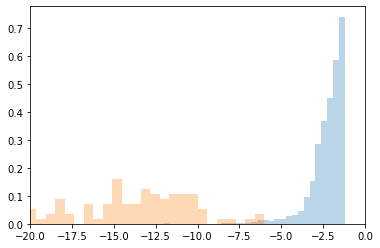

4
tensor([[-5.1156],
        [-3.8739]], grad_fn=<CopyBackwards>)
tensor([[-7.7646],
        [-8.3207]], grad_fn=<CopyBackwards>)
(5000, 2)


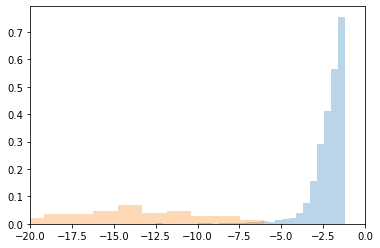

5
tensor([[-4.9280],
        [-3.7538]], grad_fn=<CopyBackwards>)
tensor([[-7.9489],
        [-9.0678]], grad_fn=<CopyBackwards>)
(5800, 2)


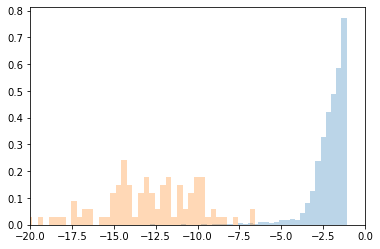

6
tensor([[-4.8928],
        [-3.6690]], grad_fn=<CopyBackwards>)
tensor([[-8.1846],
        [-9.4340]], grad_fn=<CopyBackwards>)
(6600, 2)


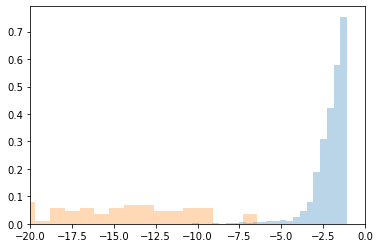

7


KeyboardInterrupt: 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = [6, 6]
cov = [[1, 0.5], [0.5, 1]]  # diagonal covariance

mean1 = [9, 9]
cov1 = [[0.5, -0.2], [-0.2, 0.5]]  # diagonal covariance

x_normal = np.random.multivariate_normal(mean, cov, 1000)
x_ab = np.random.multivariate_normal(mean1, cov1, 100)

# for num in range(1000,10000,2000):
for num in range(10):
    print(num)

    num_layers = 5
    base_dist = StandardNormal(shape=[2])

    transforms = []
    for _ in range(num_layers):
        transforms.append(ReversePermutation(features=2))
        transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                              hidden_features=4))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    flow.to(device)
    optimizer = optim.Adam(flow.parameters(), lr = 1e-3)

    num_iter = 1000
    for i in range(num_iter):
    #     x, y = datasets.make_moons(1000, noise=.05)
#         x_normal = np.random.multivariate_normal(mean, cov, num)
        x = torch.tensor(x_normal, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=x).mean()
        loss.backward()
        optimizer.step()

    # log probability of training data 

    q = torch.tensor([0.025, 0.05])
    
    log_p_normal = flow.log_prob(torch.Tensor(x_normal))
    print(torch.quantile(log_p_normal, q, keepdim=True))
    plt.figure()
    plt.hist(log_p_normal.detach().numpy(),50,density=True, alpha=0.3)

    log_p_ab = flow.log_prob(torch.Tensor(x_ab))
    print(torch.quantile(log_p_ab, 1-q, keepdim=True))
    plt.hist(log_p_ab.detach().numpy(), 50,density=True, alpha=0.3)

#   adding new generative samples 
    samples0 = flow.sample(1000)
    log_p_new = flow.log_prob(samples0)
    s_sorted, s_indices = torch.sort(log_p_new,descending=True)
    add_sample = samples0[s_indices[:800]]
    
    x_normal = np.concatenate((add_sample.detach().numpy(), x_normal),axis=0)
    print(x_normal.shape)
    
    plt.xlim([-20,0])
    plt.show()
    